In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

In [4]:
# Load the dataset
df = pd.read_csv('./masked_kiva_loans.csv')
#df.isna().sum()
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df['borrower_genders'] = df['borrower_genders'].apply(lambda x: x.split(', ')[0] if x else 'unknown')
#new_df.head(20)

In [5]:
#outlier function
def detect_outliers(df, column_name):
    # Extract the specified column as a pandas Series
    column_data = df[column_name]

    # Calculate summary statistics
    median_value = column_data.median()
    q1 = column_data.quantile(0.25)
    q3 = column_data.quantile(0.75)
    iqr = q3 - q1

    # Calculate lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = column_data[(column_data < lower_bound) | (column_data > upper_bound)]

    # Replace outliers with the corresponding bounds
    column_data = column_data.clip(lower=lower_bound, upper=upper_bound)

    # Update the DataFrame with the modified column
    df[column_name] = column_data


detect_outliers(df,"funded_amount")
detect_outliers(df,"loan_amount")
detect_outliers(df,"lender_count")
detect_outliers(df,"term_in_months")

In [6]:
#  summary statistics Group the data by sector and calculate the total funded amount
sector_funding = df.groupby('sector')['funded_amount'].sum()
print(sector_funding)
print(df.describe(include ='all'))

sector
Agriculture       5727900
Arts               403900
Clothing          1231375
Construction       241025
Education         1268825
Entertainment       28525
Food              4314075
Health             373400
Housing            987625
Manufacturing      215525
Personal Use       672850
Retail            3598325
Services          1532050
Transportation     454500
Wholesale           30875
Name: funded_amount, dtype: int64
                  id  funded_amount  loan_amount       sector      country  \
count   3.275200e+04   32752.000000  32752.00000        32752        32752   
unique           NaN            NaN          NaN           15           78   
top              NaN            NaN          NaN  Agriculture  Philippines   
freq             NaN            NaN          NaN         8870         8090   
mean    9.918740e+05     643.648479    688.95869          NaN          NaN   
std     1.975409e+05     521.255315    560.77593          NaN          NaN   
min     6.530490e+05   

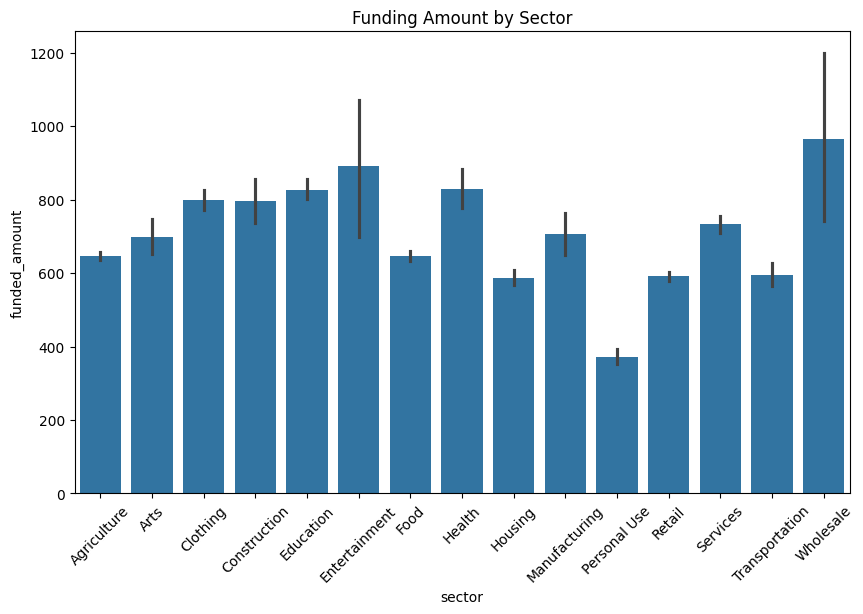

In [7]:
# Visualization Example: Funding by Sector
plt.figure(figsize=(10, 6))
sns.barplot(x='sector', y='funded_amount', data=df)
plt.xticks(rotation=45)
plt.title('Funding Amount by Sector')
plt.show()

In [8]:
# Calculate the correlation between lender count and funded amount
correlation = df['lender_count'].corr(df['funded_amount'])
print("Correlation between lender count and funded amount:", correlation)

Correlation between lender count and funded amount: 0.8610715022152271


In [9]:
# Machine Learning Model
x = df[['loan_amount', 'lender_count', 'term_in_months']]
y = df['funded_amount']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("Mean Squared Error:", mse)
print('RMSE:', np.sqrt(mse))
print('r2_score:', r2)

Mean Squared Error: 15632.984225643482
RMSE: 125.031932823753
r2_score: 0.9428876216718975


In [10]:
# Parse dates
df['date'] = pd.to_datetime(df['date'])

# Set 'Month' column as index
df.set_index('date', inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_10664\2502756655.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  funded_amount_ts = df['funded_amount'].resample('M').sum()


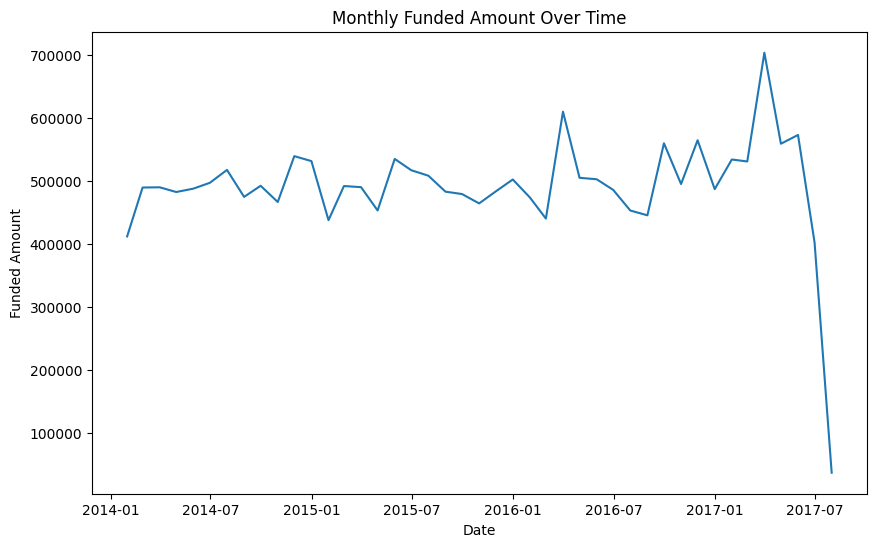

In [11]:
# Step 1: Visualize the time series
funded_amount_ts = df['funded_amount'].resample('M').sum()

plt.figure(figsize=(10, 6))
plt.plot(funded_amount_ts)
plt.title('Monthly Funded Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Funded Amount')
plt.show()

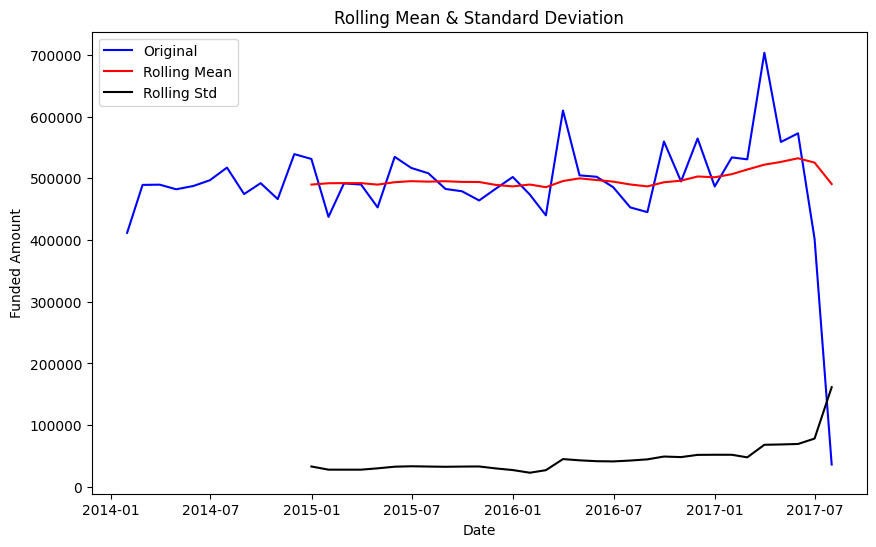

Results of Dickey-Fuller Test:
ADF Statistic: -3.652539068141864
p-value: 0.004832483399498428
Critical Values:
	1%: -3.639224104416853
	5%: -2.9512301791166293
	10%: -2.614446989619377


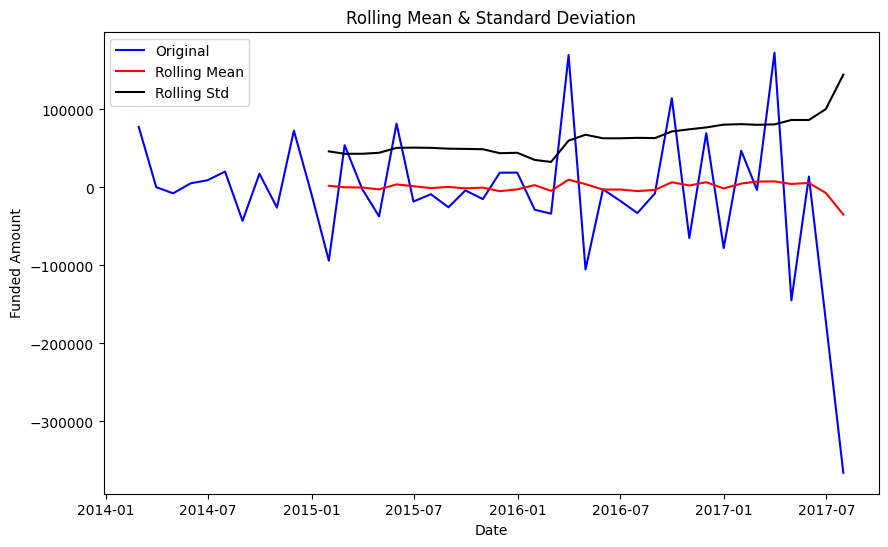

Results of Dickey-Fuller Test:
ADF Statistic: -4.351699855871736
p-value: 0.00036103568472687134
Critical Values:
	1%: -3.661428725118324
	5%: -2.960525341210433
	10%: -2.6193188033298647


In [12]:
# Step 2: Stationarize the series
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Funded Amount')
    plt.legend(loc='best')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    print('ADF Statistic:', dftest[0])
    print('p-value:', dftest[1])
    print('Critical Values:')
    for key, value in dftest[4].items():
        print('\t{}: {}'.format(key, value))

test_stationarity(funded_amount_ts)

# Differencing the series to make it stationary
funded_amount_ts_diff = funded_amount_ts.diff().dropna()
test_stationarity(funded_amount_ts_diff)



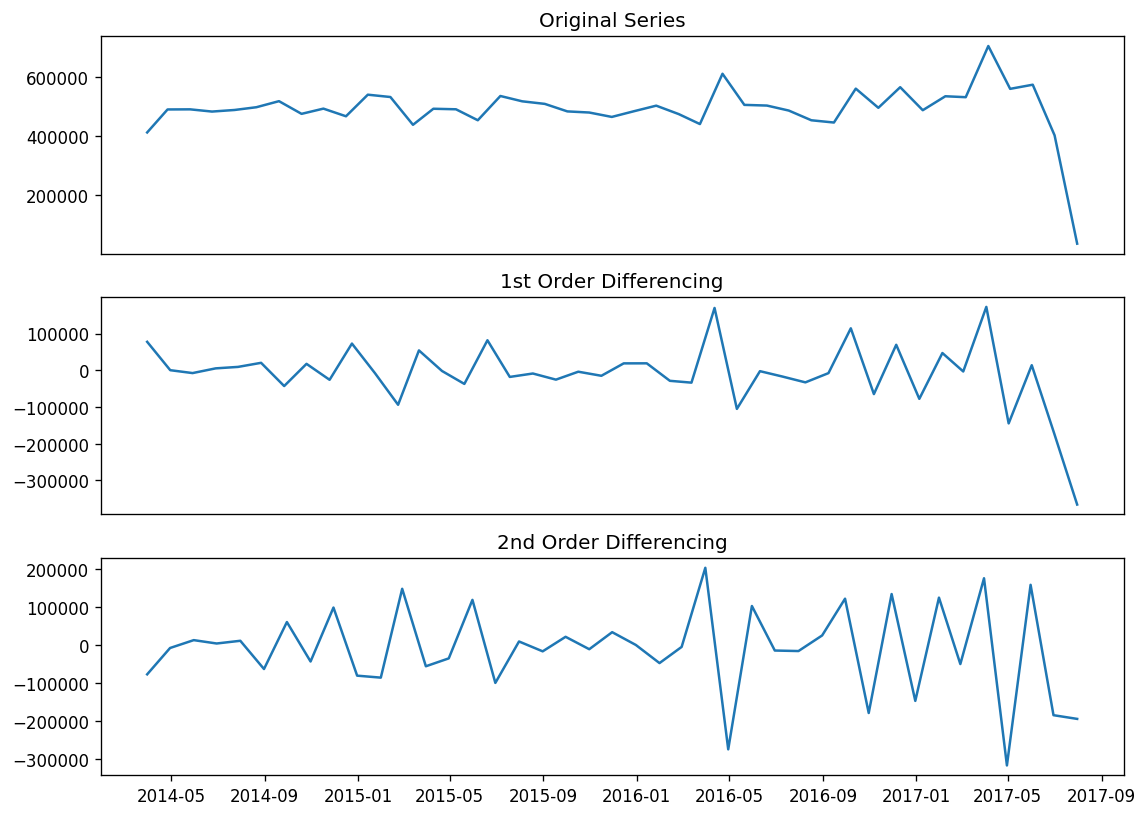

In [13]:
# Example usage:
# Visualize original series and its differences
plt.rcParams.update({'figure.figsize':(11,8), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(funded_amount_ts); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(funded_amount_ts.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(funded_amount_ts.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

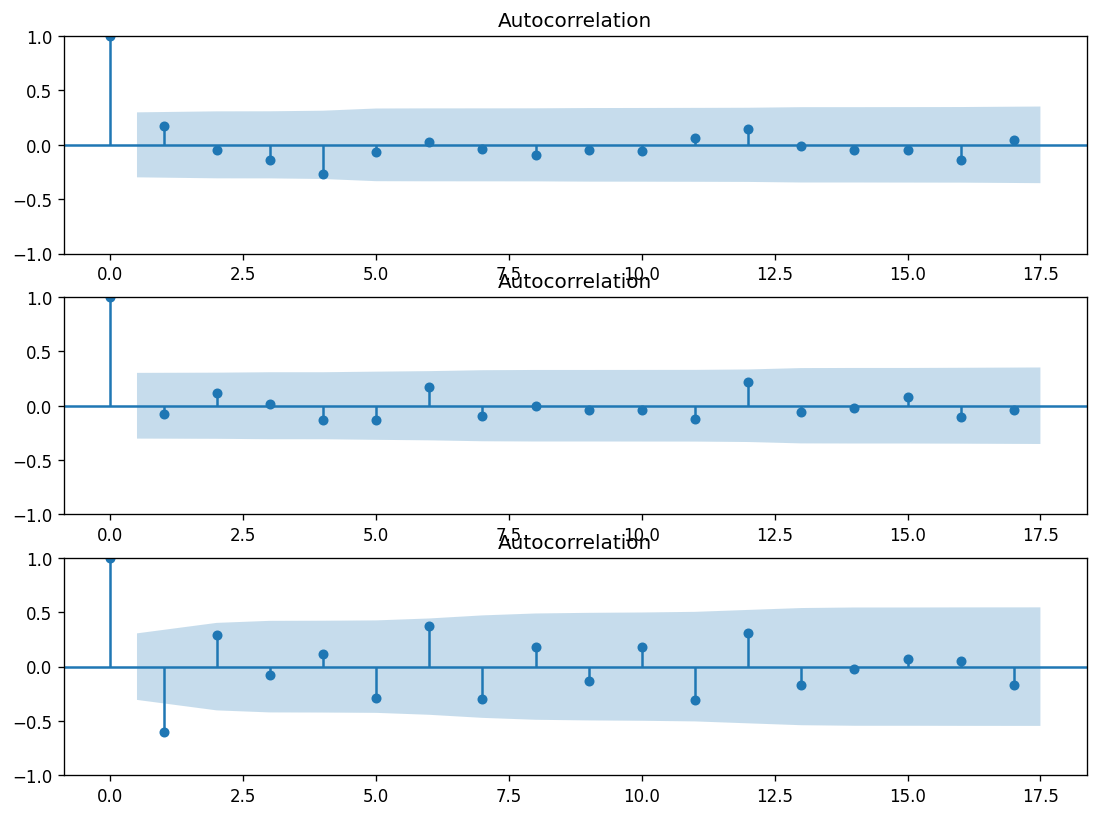

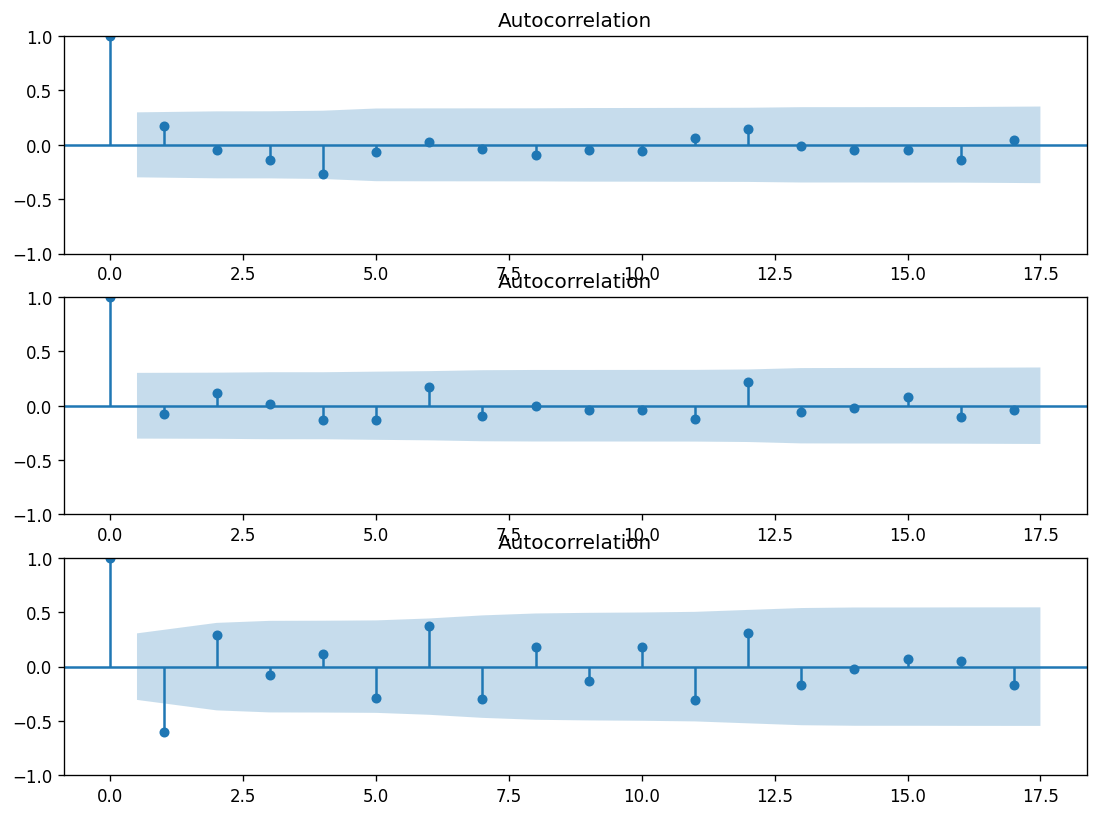

In [14]:
# Step 3: plot ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(funded_amount_ts, ax=ax1)
plot_acf(funded_amount_ts.diff().dropna(), ax=ax2)
plot_acf(funded_amount_ts.diff().diff().dropna(), ax=ax3)


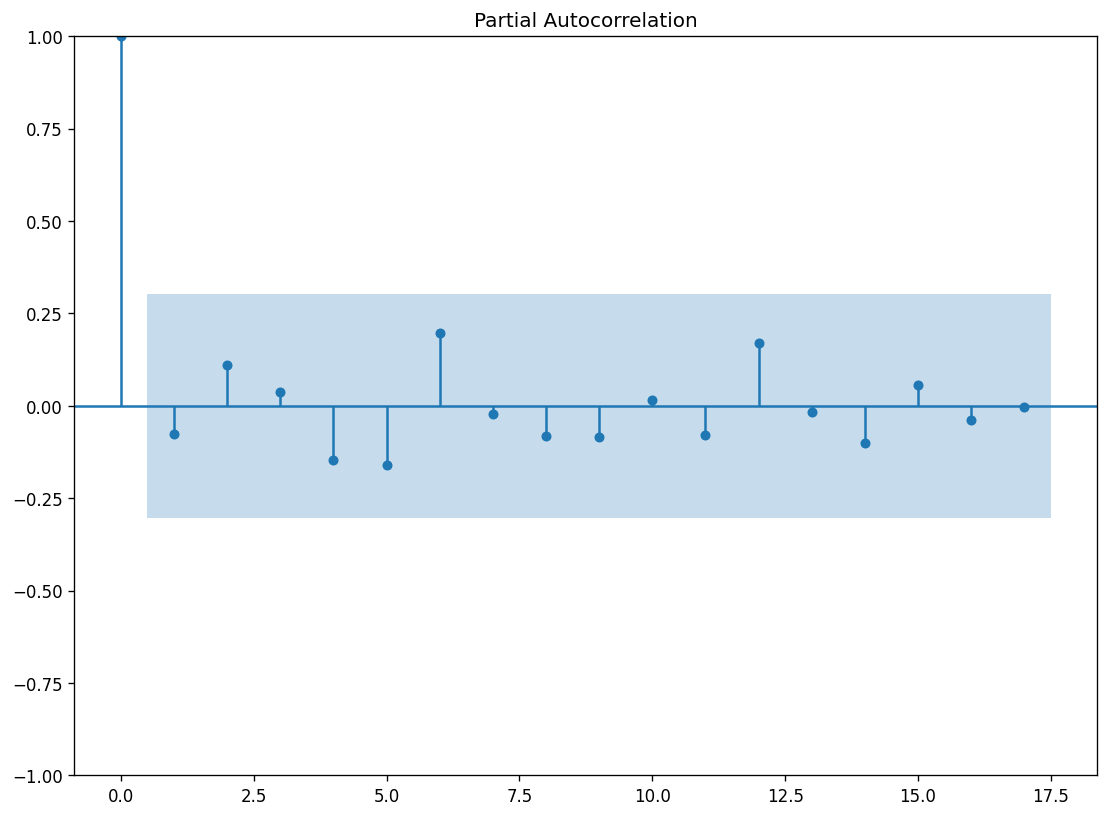

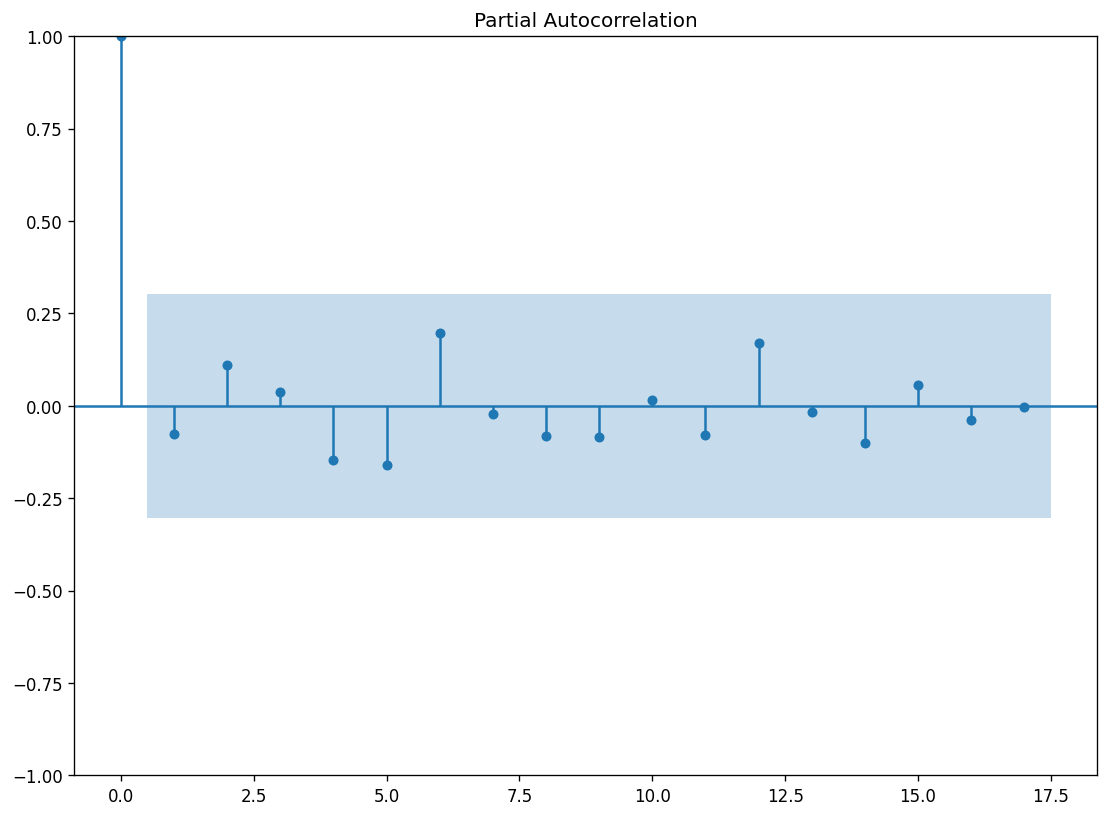

In [15]:
# Finding the value of the p parameter
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(funded_amount_ts.diff().dropna())

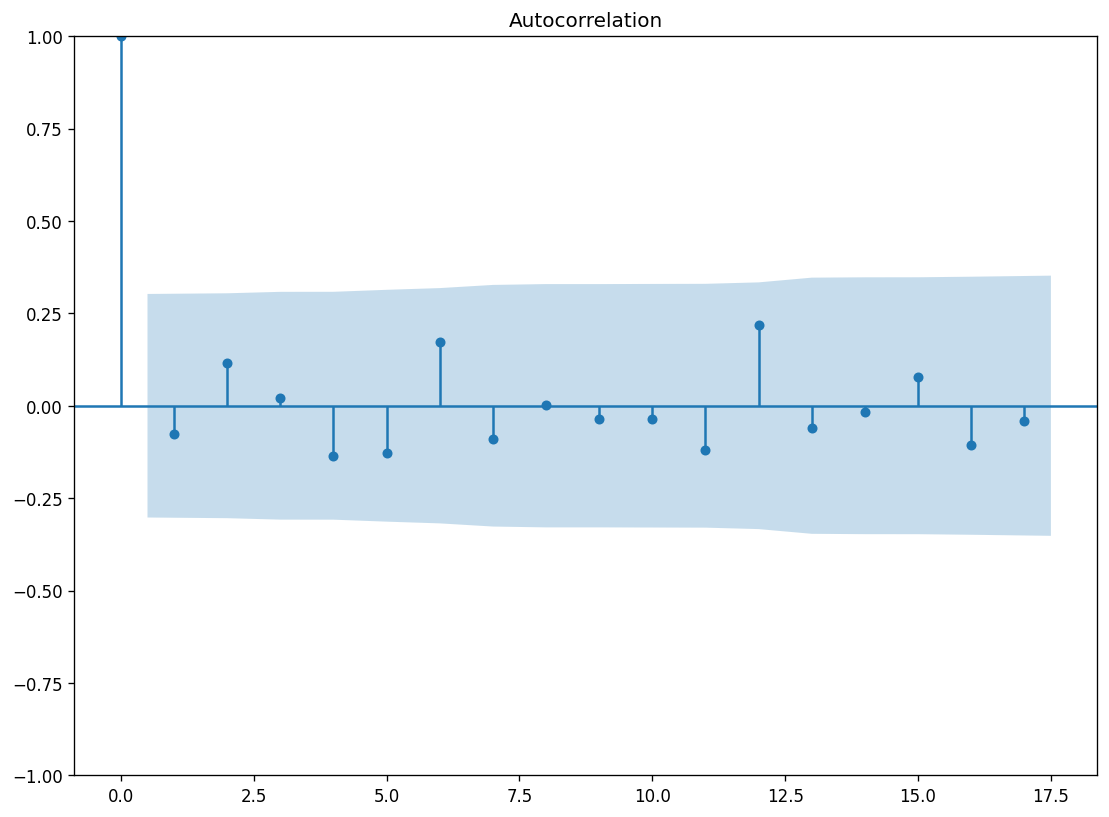

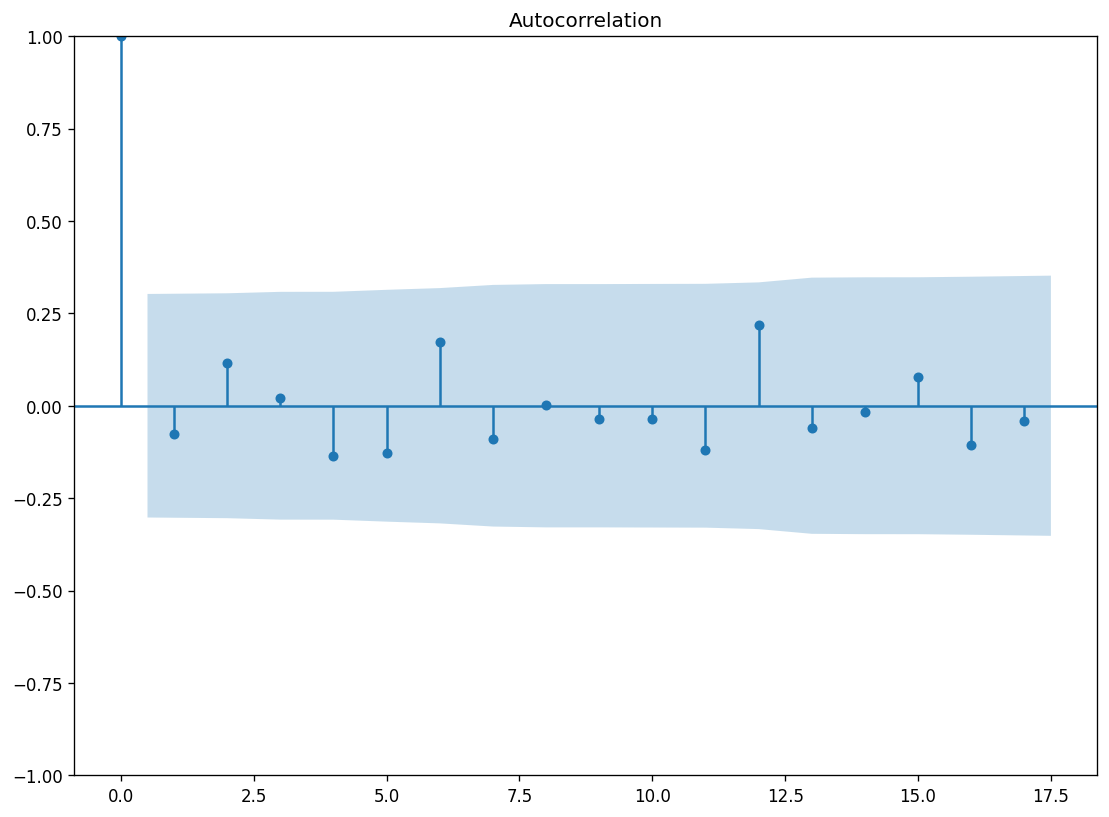

In [16]:
# Finding the value of the q parameter
plot_acf(funded_amount_ts.diff().dropna())

In [17]:
# Step 4: Build the ARIMA model
model = ARIMA(funded_amount_ts, order=(1, 1, 1))
arima_model = model.fit()

C:\Users\PC\AppData\Local\Temp\ipykernel_10664\1215340983.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=funded_amount_ts.index[-1], periods=forecast_steps, freq='M')


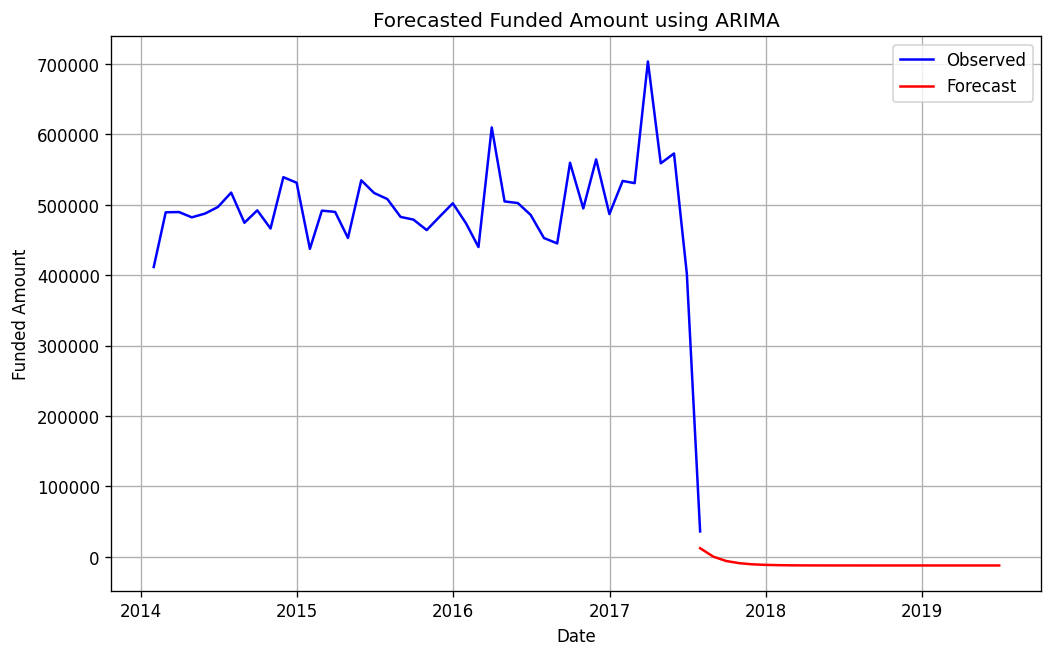

In [18]:

# Step 5: Forecast
forecast_steps = 24  # Adjust as needed
forecast_index = pd.date_range(start=funded_amount_ts.index[-1], periods=forecast_steps, freq='M')
forecast = arima_model.forecast(steps=forecast_steps)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(funded_amount_ts.index, funded_amount_ts, label='Observed', color='blue')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Forecasted Funded Amount using ARIMA')
plt.xlabel('Date')
plt.ylabel('Funded Amount')
plt.legend()
plt.grid(True)
plt.show()


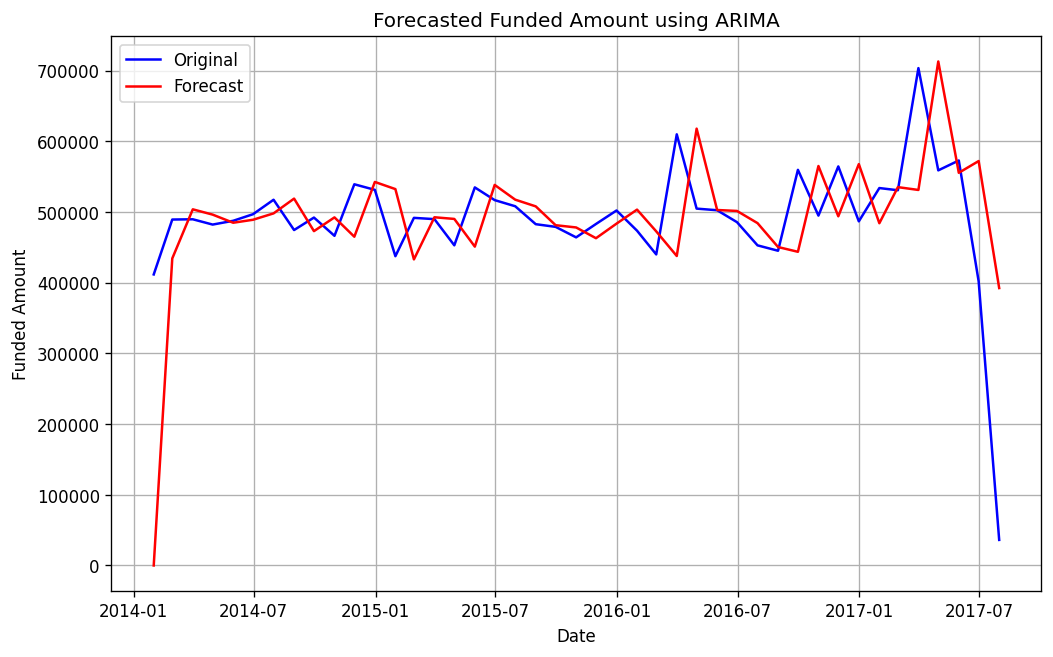

In [19]:
forecast = arima_model.predict(start=funded_amount_ts.index[0], end=funded_amount_ts.index[-1], typ='levels')
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(funded_amount_ts, label='Original', color='blue')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Forecasted Funded Amount using ARIMA')
plt.xlabel('Date')
plt.ylabel('Funded Amount')
plt.legend()
plt.grid(True)
plt.show()